## 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
from time import time
from MomentLearn import utils
from MomentLearn import model as model_utils
from MomentLearn.model import LinearMoment, ContrastiveLearn, RNNMoment, sample_double_proteins_with_sim_dist, loss_func
import prody as pd
import matplotlib.pyplot as plt
from caretta.score_functions import get_caretta_score
from caretta.multiple_alignment import tm_score
from caretta import superposition_functions, helper, multiple_alignment
import umap
from caretta import dynamic_time_warping as dtw

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
X_names, mapk_pdb_id_to_class = utils.get_example_metadata()
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
mapping = [class_mapping[mapk_pdb_id_to_class[k]] for k in X_names]

In [10]:
start_time = time()
pdbs = []
for i, (pdb_id, chain) in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins fetched in {(time() - start_time):.2f} seconds")
    pdbs.append(pd.parsePDB(pdb_id, chain=chain))

In [5]:
from geometricus import MomentInvariants, SplitType, MomentType

invariants_kmer = []
invariants_kmer2 = []
invariants_radius = []

start_time = time()
for i, key in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins in {(time() - start_time):.2f} seconds")
    invariants_kmer.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.KMER, split_size=6, moment_types=list(MomentType)))
    invariants_kmer2.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.KMER, split_size=12, moment_types=list(MomentType)))
    invariants_radius.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.RADIUS, split_size=10, moment_types=list(MomentType)))

50 proteins in 13.22 seconds
100 proteins in 17.05 seconds
150 proteins in 21.19 seconds
200 proteins in 25.06 seconds
250 proteins in 28.87 seconds
300 proteins in 32.76 seconds
350 proteins in 36.51 seconds
400 proteins in 40.25 seconds
450 proteins in 44.28 seconds
500 proteins in 47.93 seconds


In [6]:
ind_moments_kmer = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 6).astype("float32") for x in invariants_kmer]
ind_moments_kmer2 = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 12).astype("float32") for x in invariants_kmer2]
ind_moments_radius = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 10).astype("float32") for x in invariants_radius]
ind_moments = [np.hstack((ind_moments_kmer[i], ind_moments_kmer2[i], ind_moments_radius[i])) for i in range(len(ind_moments_radius))]

In [7]:
def unpack_and_desort(x, sizes, desort_idx):
    x, sizes = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
    x = x[np.arange(x.shape[0]), sizes-1]
    x = x[np.argsort(desort_idx)]
    return x

In [8]:
from MomentLearn.model import LinearMoment, ContrastiveLearn, RNNMoment, sample_double_proteins_with_sim_dist, loss_func

batch_size = 150 
rnn_model = RNNMoment(2, len(ind_moments[0][0]), 20, 2, batch_size=batch_size)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.0005)
epoch = 400

In [9]:

current_losses = []
rnn_model.batch_size = batch_size
for e in range(epoch):
    (x1, sizes1, sort_idx1), (x2, sizes2, sort_idx2), which = sample_double_proteins_with_sim_dist(ind_moments, np.array(mapping), batch=batch_size)
    hidden_batch1 = rnn_model.init_hidden()
    hidden_batch2 = rnn_model.init_hidden()
    (x1, h1), (x2, h2) = rnn_model(x1, x2, hidden_batch1, hidden_batch2, sizes1, sizes2)
#     break
    x1, x2 = h1[-1][np.argsort(sort_idx1)], h2[-1][np.argsort(sort_idx2)]
#     x1 = unpack_and_desort(x1, sizes1, sort_idx1)
#     x2 = unpack_and_desort(x2, sizes2, sort_idx2)
    loss = loss_func(x1, x2, which)
    optimizer.zero_grad()
    loss.backward()
    current_losses.append(loss.item())
    optimizer.step()

    if e % 50 == 0:
        print(np.mean(current_losses))
        current_losses = []


0.22380641102790833
0.14837509498000145
0.0684037434309721
0.05828062564134598
0.049576320499181745
0.049696894139051435
0.047889508977532386
0.04529487136751413


In [11]:
sizes = np.array([len(x) for x in ind_moments])
sort_idx = np.argsort(sizes)[::-1]
sizes = sizes[sort_idx]
all_moments = torch.tensor(np.concatenate(np.array(ind_moments)[sort_idx]).astype("float32"))
rnn_model.batch_size = len(ind_moments)
hidden = rnn_model.init_hidden()
res = rnn_model.forward_single(all_moments, hidden, sizes)
# res = unpack_and_desort(res[0], sizes, sort_idx).detach().cpu().numpy()
res = res[1][-1].detach().cpu().numpy()[np.argsort(sort_idx)]


No handles with labels found to put in legend.


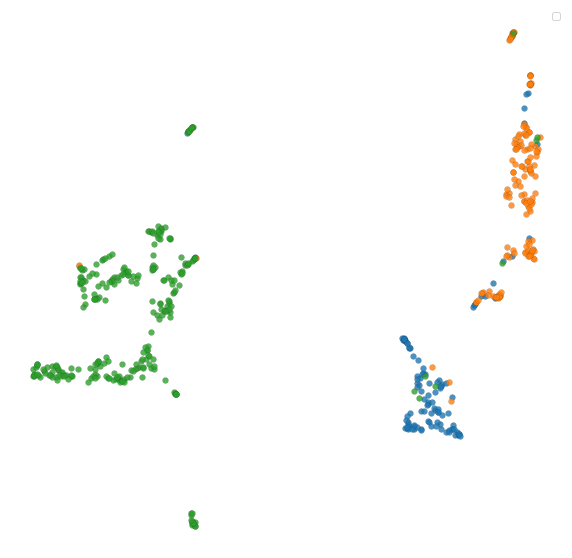

In [12]:

reducer = umap.UMAP(metric="cosine", n_components=2)
reduced = reducer.fit_transform(res)
# reduced = res
plt.figure(figsize=(10,10))
for i in range(3):
    indices = np.where(np.array(mapping) == i)[0]
    plt.scatter(reduced[indices, 0],
                reduced[indices, 1],
                edgecolor="black",
                linewidth=0.1,
                alpha=0.8)
plt.axis("off")
plt.legend()
plt.show()

In [13]:
proteins = [rnn_model.linear_moment(torch.tensor(x.astype("float32"))).cpu().detach().numpy() for x in ind_moments]
residue_coords = [x.coordinates for x in invariants_kmer]

In [14]:
i1 = 3
i2 = -1
protein_a = proteins[i1]
protein_b = proteins[i2]
coords_a = residue_coords[i1]
coords_b = residue_coords[i2]

In [15]:
def svd_superimpose(coords_1, coords_2):
    centroid_1, centroid_2 = (
        helper.nb_mean_axis_0(coords_1),
        helper.nb_mean_axis_0(coords_2),
    )
    coords_1_c, coords_2_c = coords_1 - centroid_1, coords_2 - centroid_2
    correlation_matrix = np.dot(coords_2_c.T, coords_1_c)
    u, s, v = np.linalg.svd(correlation_matrix)
    reflect = np.linalg.det(u) * np.linalg.det(v) < 0
    if reflect:
        s[-1] = -s[-1]
        u[:, -1] = -u[:, -1]
    rotation_matrix = np.dot(u, v)
    translation_matrix = centroid_1 - np.dot(centroid_2, rotation_matrix)
    return rotation_matrix.astype(np.float64), translation_matrix.astype(np.float64)

In [16]:
score_matrix = np.array([[np.abs(x - y).sum() for y in protein_b] for x in protein_a])
score_matrix = score_matrix.max() - score_matrix
p1_idx, p2_idx, _ = dtw.dtw_align(score_matrix, gap_open_penalty=1, gap_extend_penalty=.5)

In [17]:
def score(coords1, coords2, gamma=2):
    rot, trans = svd_superimpose(np.array(coords1).astype(float), np.array(coords2).astype(float))
    coords2_rotated = np.dot(coords2 - np.mean(coords2, axis=0), rot)
    coords1_translated = coords1 - np.mean(coords1, axis=0)
    return get_caretta_score(coords1_translated, coords2_rotated).mean(), (coords1_translated, coords2_rotated)

core_p1_idx, core_p2_idx = helper.get_common_positions(p1_idx, p2_idx)
aligned_score, (p1_rotated_common, p2_rotated_common) = score(coords_a[core_p1_idx], coords_b[core_p2_idx])
unaligned_score, _ = score(coords_a[:min(coords_a.shape[0], coords_b.shape[0])], coords_b[:min(coords_a.shape[0], coords_b.shape[0])])
aligned_score, unaligned_score

(0.8119937342913593, 0.036702942631759244)

In [18]:
def fill_gaps_for_plotting(alignment_idx):
    while np.where(alignment_idx == -1)[0].shape[0] != 0:
        current = np.where(alignment_idx == -1)[0][0]
        if current == 0:
            alignment_idx[current] = alignment_idx[np.where(alignment_idx != -1)[0][0]]
        else:
            alignment_idx[current] = alignment_idx[current - 1]
    return alignment_idx

In [19]:
p1_idx_filled, p2_idx_filled = fill_gaps_for_plotting(p1_idx), fill_gaps_for_plotting(p2_idx)

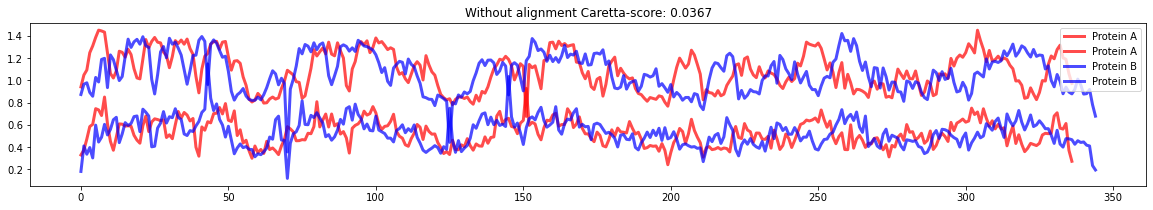

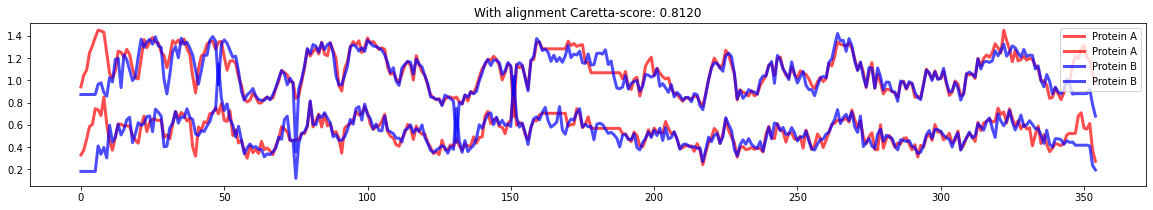

In [27]:
plt.figure(figsize=(20,3))
plt.plot(protein_a, lw=3, alpha=.7, c="r", label="Protein A")
plt.plot(protein_b, lw=3, alpha=.7, c="b", label="Protein B")
plt.title(f"Without alignment Caretta-score: {unaligned_score:.4f}")
plt.legend()
plt.show()
plt.figure(figsize=(20,3))
plt.plot(protein_a[p1_idx_filled], lw=3, alpha=.7, c="r", label="Protein A")
plt.plot(protein_b[p2_idx_filled], lw=3, alpha=.7, c="b", label="Protein B")
plt.title(f"With alignment Caretta-score: {aligned_score:.4f}")
plt.legend()
plt.show()